**Curso:** Bacharelado em Inteligência Artificial

**Disciplina:** Visão computacional

**Tema:** Detecção de características X Extração de descritores

*Este código foi desenvolvido para fins educacionais.*

# Mini Projeto: Parte 3 — Correspondência de Características (Matching)

Nesta etapa, testamos técnicas de matching entre grafites em diferentes imagens, utilizando o algoritmo ORB, variando parâmetros e comparando os resultados entre imagens da etapa de morfologia e da etapa de detecção de bordas.



## Sobre o Conjunto de Imagens

O conjunto total tem quase 1000 imagens, o que tornaria a comparação entre todos os pares inviável computacionalmente. Por isso, **limitamos os experimentos a um subconjunto de 10 imagens** representativas, escolhidas entre aquelas processadas pela etapa de morfologia (pasta `data/morphology/`). O mesmo pode ser feito para a pasta `data/processed/` para comparação.

In [24]:
import os

# Seleção automática de 50 imagens (pode personalizar ou sortear outras)
input_folder = '../data/morphology/'
image_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.jpg') or f.endswith('.png')])[:50]
print('Imagens selecionadas:', image_files)

Imagens selecionadas: ['canny_0.jpg', 'canny_1.jpg', 'canny_10.jpg', 'canny_100.jpg', 'canny_101.jpg', 'canny_102.jpg', 'canny_103.jpg', 'canny_104.jpg', 'canny_105.jpg', 'canny_106.jpg', 'canny_107.jpg', 'canny_108.jpg', 'canny_109.jpg', 'canny_11.jpg', 'canny_110.jpg', 'canny_111.jpg', 'canny_112.jpg', 'canny_113.jpg', 'canny_114.jpg', 'canny_115.jpg', 'canny_116.jpg', 'canny_117.jpg', 'canny_118.jpg', 'canny_119.jpg', 'canny_12.jpg', 'canny_120.jpg', 'canny_121.jpg', 'canny_122.jpg', 'canny_123.jpg', 'canny_124.jpg', 'canny_125.jpg', 'canny_126.jpg', 'canny_127.jpg', 'canny_128.jpg', 'canny_129.jpg', 'canny_13.jpg', 'canny_130.jpg', 'canny_131.jpg', 'canny_132.jpg', 'canny_133.jpg', 'canny_134.jpg', 'canny_135.jpg', 'canny_136.jpg', 'canny_137.jpg', 'canny_138.jpg', 'canny_139.jpg', 'canny_14.jpg', 'canny_140.jpg', 'canny_141.jpg', 'canny_142.jpg']


Função de Matching (com tratamento do erro do knn)

In [25]:
import cv2

def match_images(img1, img2, n_features=500, lowe_ratio=0.75):
    orb = cv2.ORB_create(nfeatures=n_features)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        return [], kp1, kp2

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m_n in matches:
        if len(m_n) == 2:
            m, n = m_n
            if m.distance < lowe_ratio * n.distance:
                good_matches.append(m)
    return good_matches, kp1, kp2

Parâmetros Iniciais de Matching

In [35]:
N_FEATURES = 800
LOWE_RATIO_THRESHOLD = 0.65
MIN_MATCHES_THRESHOLD = 15
TOP_N_SIMILAR = 5

output_folder = f'../data/matches/matches_n{N_FEATURES}_r{int(LOWE_RATIO_THRESHOLD*100)}/'
os.makedirs(output_folder, exist_ok=True)


#### Com N_FEATURES em 500, LOWE_RATIO em 0.75 e MIN_MATCHES EM 10 - ocorreram 141 resultados
#### Com N_FEATURES em 1000, LOWE_RATIO em 0.60 e MIN_MATCHES EM 10 - ocorreram apenas 10 resultados de maior qualidade
#### Com N_FEATURES em 800, LOWE_RATIO em 0.65 e MIN_MATCHES EM 15 - ocorreram apenas 5 resultados com grande similaridade

## OS RESULTADOS FORAM SALVOS EM DIFERENTES PASTAS DENTRO DA PASTA MATCHES


Rodando o Matching só no subconjunto escolhido

In [33]:
from itertools import combinations

similarities = []

for img1_name, img2_name in combinations(image_files, 2):
    img1 = cv2.imread(os.path.join(input_folder, img1_name), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(os.path.join(input_folder, img2_name), cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None:
        continue
    matches, kp1, kp2 = match_images(img1, img2, n_features=N_FEATURES, lowe_ratio=LOWE_RATIO_THRESHOLD)
    if len(matches) >= MIN_MATCHES_THRESHOLD:
        similarities.append((img1_name, img2_name, len(matches)))
        match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)
        save_path = os.path.join(output_folder, f'{img1_name[:-4]}_{img2_name[:-4]}.jpg')
        cv2.imwrite(save_path, match_img)

similarities.sort(key=lambda x: -x[2])
print(f'Top {TOP_N_SIMILAR} pares com mais correspondências:')
for i in range(min(TOP_N_SIMILAR, len(similarities))):
    print(similarities[i])


Top 5 pares com mais correspondências:
('canny_121.jpg', 'canny_136.jpg', 47)
('canny_109.jpg', 'canny_112.jpg', 33)
('canny_121.jpg', 'canny_128.jpg', 24)
('canny_121.jpg', 'canny_122.jpg', 21)
('canny_109.jpg', 'canny_136.jpg', 19)


Visualizando os Melhores Matchings

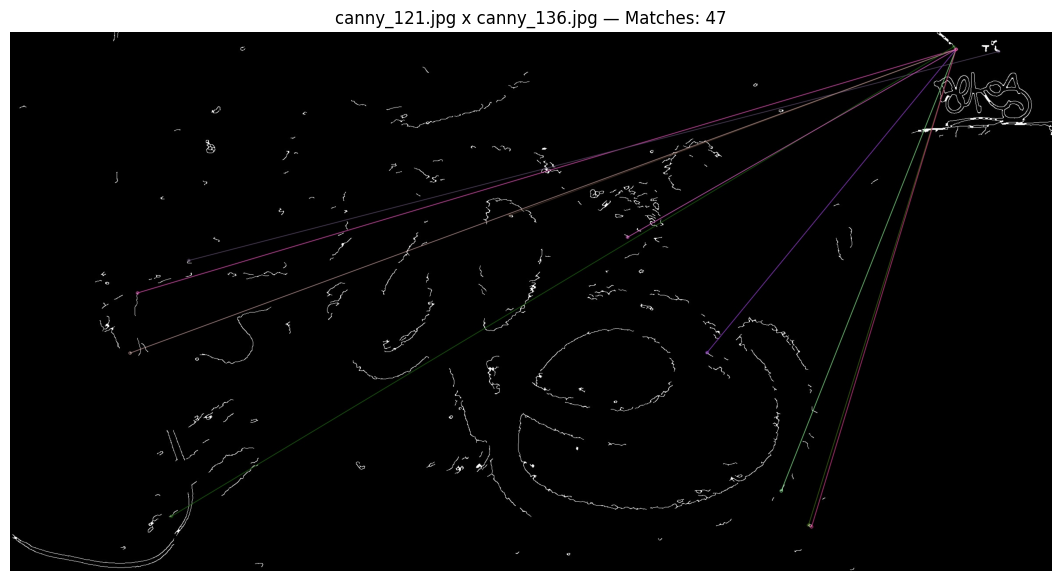

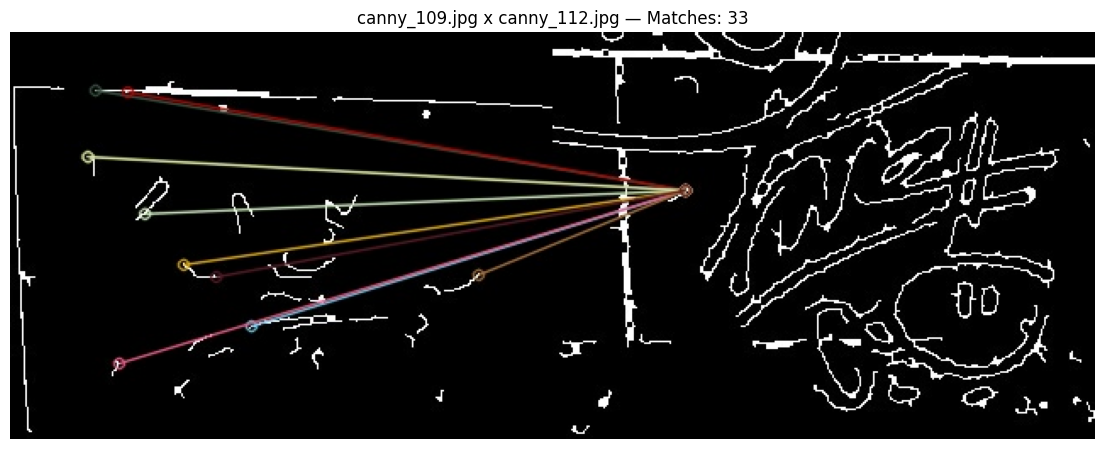

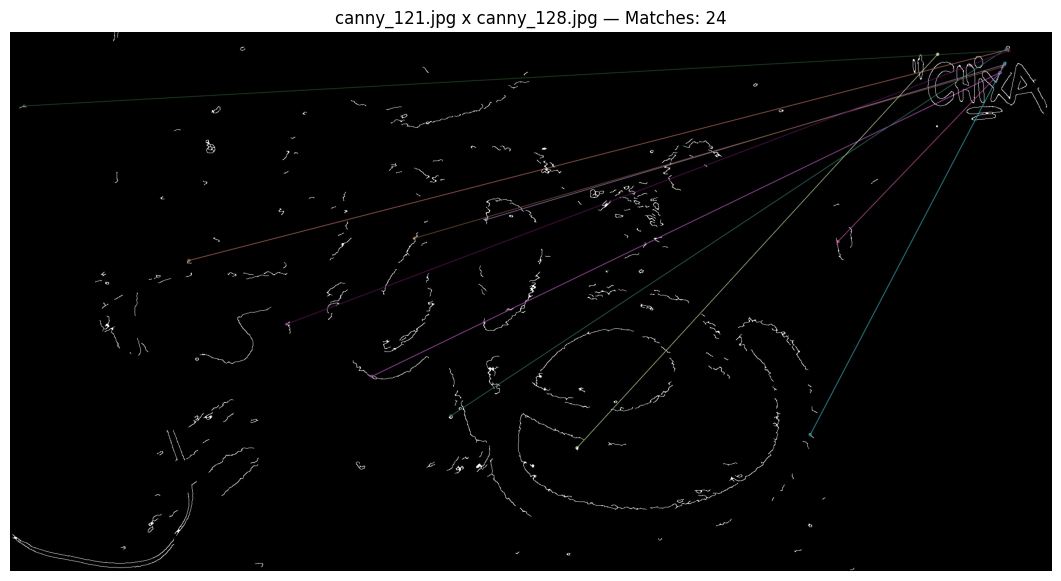

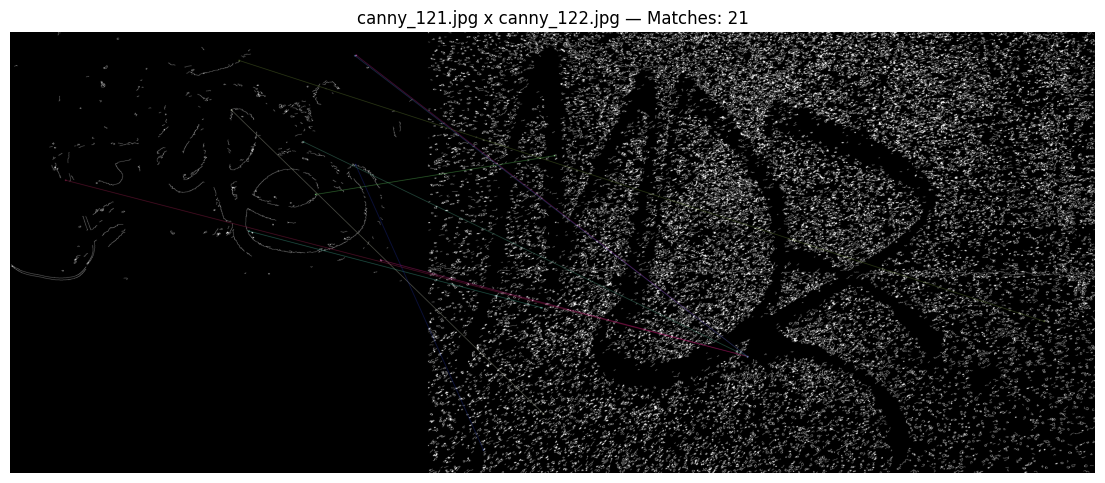

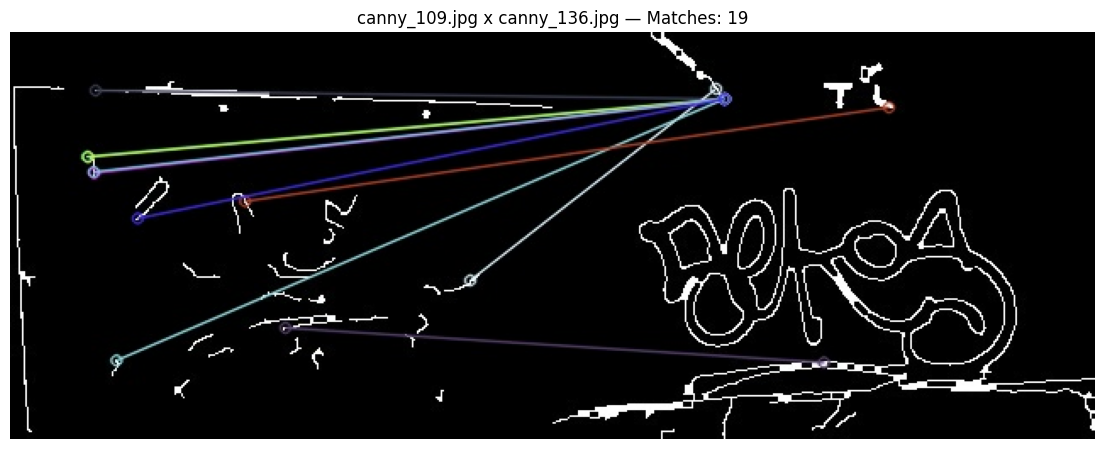

In [34]:
import matplotlib.pyplot as plt
from PIL import Image

for i in range(min(TOP_N_SIMILAR, len(similarities))):
    img1_name, img2_name, n_matches = similarities[i]
    file_name = f'{img1_name[:-4]}_{img2_name[:-4]}.jpg'
    img = Image.open(os.path.join(output_folder, file_name))
    plt.figure(figsize=(14, 7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{img1_name} x {img2_name} — Matches: {n_matches}')
    plt.show()


## Influência dos Parâmetros

- **N_FEATURES** (número de pontos detectados)
- **LOWE_RATIO_THRESHOLD** (restrição de similaridade)
- **MIN_MATCHES_THRESHOLD** (mínimo de matches para salvar)
- **TOP_N_SIMILAR** (quantos pares exibir)

## Respostas

### 1. Se eu usar a pasta processed e depois usar a pasta morphology, os resultados serão os mesmos? Justifique sua resposta.

Não. A pasta `morphology` contém imagens refinadas por operações morfológicas, tornando as bordas mais contínuas e facilitando o matching. Na pasta `processed`, as bordas podem estar mais quebradas, dificultando a correspondência. Portanto, os resultados são diferentes.

### 2. Se ajustar os parâmetros, os pares de imagens mudam muito?

Sim. Parâmetros como `N_FEATURES` e `LOWE_RATIO_THRESHOLD` mudam a quantidade e a qualidade dos matches, alterando quais pares aparecem como os mais similares.

### 3. O algoritmo que usou atende bem o esperado? E quais outros você testou?

O ORB funciona muito bem para imagens em tons de cinza e bordas, além de ser rápido. AKAZE e BRISK também são alternativas gratuitas, mas o ORB já é suficiente para o objetivo do mini-projeto.

---

**Observação**: Limitar o experimento a um subconjunto pequeno não prejudica o aprendizado ou as comparações exigidas, e ainda deixa o trabalho viável e bem documentado.



## Conclusão

A etapa de correspondência permite encontrar grafites similares entre diferentes imagens, usando ORB e pós-processamento morfológico. Parâmetros bem ajustados são essenciais para bons resultados e menos falsos positivos.
